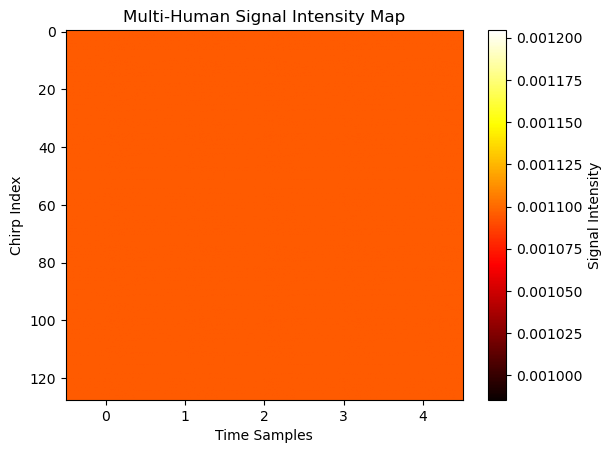

In [1]:
import numpy as np

# Radar parameters
f0 = 77e9                 # Start frequency in Hz (77 GHz for radar)
B = 4e9                   # Sweep bandwidth (4 GHz typical)
T = 5.5e-6                # Chirp duration (5.5 microseconds)
I = 128                   # Number of chirps per CPI
c = 3e8                   # Speed of light (m/s)
gamma = 0.1               # Attenuation coefficient

# Reflection points (positions of humans and objects in meters)
objects = [
    {"position": np.array([10, 0]), "RCS": 0.8, "Radial Velocity": 1},
    {"position": np.array([15, 10]), "RCS": 0.5, "Radial Velocity": 1},
    {"position": np.array([20, -5]), "RCS": 0.6, "Radial Velocity": 1},
]

# Radar position
radar_position = np.array([0, 0])

# Function to calculate the time delay for a given position
def calculate_time_delay(radar_pos, obj_pos):
    distance = np.linalg.norm(radar_pos - obj_pos)
    return 2 * distance / c  # Round-trip time delay

# Simulate transmitting chirps
def transmit_chirp(i):
    t = np.linspace(0, T, int(T * 1e6))  # Time samples
    return np.exp(1j * 2 * np.pi * (f0 * t + (B / (2 * T)) * t**2))

# Calculate received signal for each object after reflection and attenuation
def receive_chirp(i, objects, radar_position):
    received_signal = np.zeros(int(T * 1e6), dtype=complex)
    tx_chirp = transmit_chirp(i)
    
    for obj in objects:
        # Calculate round-trip time delay for each object
        tau = calculate_time_delay(radar_position, obj["position"])
        # Attenuation due to distance and reflection coefficient
        distance = np.linalg.norm(radar_position - obj["position"])
        attenuation = obj["RCS"] / (distance**2) * gamma

        # Shift and attenuate transmitted chirp to simulate reflection
        shifted_chirp = np.roll(tx_chirp, int(tau * 1e6)) * attenuation
        received_signal += shifted_chirp  # Accumulate signal from each reflection

    return received_signal

# Main simulation for all chirps
def simulate_radar():
    intensity_map = np.zeros((I, int(T * 1e6)), dtype=complex)  # I chirps, time samples
    for i in range(I):
        intensity_map[i, :] = receive_chirp(i, objects, radar_position)
    return intensity_map

# Run the simulation
intensity_map = simulate_radar()

# Visualize signal intensity map (optional)
import matplotlib.pyplot as plt
plt.imshow(np.abs(intensity_map), aspect='auto', cmap='hot')
plt.colorbar(label="Signal Intensity")
plt.xlabel("Time Samples")
plt.ylabel("Chirp Index")
plt.title("Multi-Human Signal Intensity Map")
plt.show()


In [ ]:
from raysect.primitive import Intersect, Subtract, Box, Cylinder, Sphere
from raysect.optical import World, Node, Point3D, translate, rotate, d65_white, ConstantSF
from raysect.optical.observer import PinholeCamera, RGBPipeline2D, RGBAdaptiveSampler2D
from raysect.optical.material import Lambert
from raysect.optical.material.emitter import UniformSurfaceEmitter, Checkerboard
from raysect.optical.library import schott

import matplotlib.pyplot as plt


# Box defining the ground plane
ground = Box(lower=Point3D(-50, -1.51, -50), upper=Point3D(50, -1.5, 50), material=Lambert())

# checker board wall that acts as emitter
emitter = Box(lower=Point3D(-10, -10, 10), upper=Point3D(10, 10, 10.1),
              material=Checkerboard(4, d65_white, d65_white, 0.1, 2.0), transform=rotate(45, 0, 0))

# Sphere
# Note that the sphere must be displaced slightly above the ground plane to prevent numerically issues that could
# cause a light leak at the intersection between the sphere and the ground.
sphere = Sphere(radius=1.5, transform=translate(0, 0.0001, 0), material=schott("N-BK7"))


# processing pipeline (human vision like camera response)
rgb = RGBPipeline2D()

# camera
camera = PinholeCamera(pixels=(512, 512), fov=45, pipelines=[rgb], transform=translate(0, 10, -10) * rotate(0, -45, 0))

# camera - pixel sampling settings
camera.pixel_samples = 250
camera.min_wavelength = 375.0
camera.max_wavelength = 740.0
camera.spectral_bins = 15
camera.spectral_rays = 1


world = World()

sphere.parent = world
ground.parent = world
emitter.parent = world
camera.parent = world



plt.ion()
camera.observe()

plt.ioff()
rgb.save("render.png")
rgb.display()

In [1]:
import numpy as np

def radar_signal_transmission(f0, B, T, gamma, num_chirps, sampling_rate, num_samples):
    """
    Simulates radar signal transmission and receiving.
    
    Parameters:
    - f0: Start frequency (Hz)
    - B: Sweep bandwidth (Hz)
    - T: Chirp duration (s)
    - gamma: Attenuation coefficient
    - num_chirps: Number of chirps in one coherent processing interval (CPI)
    - sampling_rate: Sampling frequency (Hz)
    - num_samples: Number of samples per chirp
    
    Returns:
    - transmitted_signal: Complex transmitted signal array
    """
    t = np.linspace(0, T, num_samples)  # Time vector for one chirp
    transmitted_signal = np.exp(1j * 2 * np.pi * (f0 * t + (B / (2 * T)) * t**2))
    return transmitted_signal


def multipath_reflection_and_attenuation(tx_signal, humans, environment, gamma=0.1):
    """
    Simulates multipath reflection and attenuation among multiple humans and environment.
    
    Parameters:
    - tx_signal: Transmitted radar signal
    - humans: List of human vertices [(x, y, z, velocity), ...]
    - environment: List of reflective surfaces [(normal_vector, point_on_surface), ...]
    - gamma: Attenuation coefficient
    
    Returns:
    - intensity_map: Map of signal intensities after multipath reflections
    """
    c = 3e8  # Speed of light (m/s)
    wavelength = c / (tx_signal.shape[0] * gamma)  # Approximate wavelength
    
    intensity_map = np.zeros((len(humans), len(tx_signal)), dtype=complex)

    for i, human in enumerate(humans):
        x, y, z, velocity = human
        total_signal = 0
        
        # Direct reflection from human
        for chirp_idx, tx in enumerate(tx_signal):
            distance = np.sqrt(x**2 + y**2 + z**2)  # Euclidean distance to human
            delay = 2 * distance / c
            attenuation = np.exp(-gamma * distance)
            total_signal += attenuation * np.exp(1j * 2 * np.pi * velocity * delay)
        
        # Multipath reflections
        for surface_normal, point in environment:
            reflected_signal = 0
            for chirp_idx, tx in enumerate(tx_signal):
                # Reflection calculations
                reflected_distance = np.linalg.norm(point - np.array([x, y, z]))
                delay = 2 * reflected_distance / c
                attenuation = np.exp(-gamma * reflected_distance)
                reflected_signal += attenuation * np.exp(1j * 2 * np.pi * velocity * delay)
            total_signal += reflected_signal

        intensity_map[i] = np.abs(total_signal)
    
    return intensity_map


# Example Usage

# Radar parameters
f0 = 77e9  # Start frequency (Hz)
B = 100e6  # Bandwidth (Hz)
T = 60e-6  # Chirp duration (s)
gamma = 0.1  # Attenuation coefficient
num_chirps = 128
sampling_rate = 5e6  # Sampling frequency (Hz)
num_samples = 256

# Generate transmitted signal
tx_signal = radar_signal_transmission(f0, B, T, gamma, num_chirps, sampling_rate, num_samples)

# Define humans as a list of (x, y, z, velocity)
humans = [(1.5, 0, 0, 1), (2.5, 1, 0.5, 0.5), (3.5, -1, 1, -0.2)]

# Define environment surfaces as [(normal_vector, point_on_surface)]
environment = [((0, 0, 1), (0, 0, 0)), ((1, 0, 0), (5, 0, 0))]  # Floor and wall

# Simulate reflections
intensity_map = multipath_reflection_and_attenuation(tx_signal, humans, environment, gamma)

# Visualize or use the intensity map
print("Intensity Map:")
print(intensity_map)


Intensity Map:
[[621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j 621.0826349 +0.j
  621

In [ ]:
#Load in the model
# Work out the RCS of each vertex with respoect to the radar emitter (set this at a certain point)
# 